# Conversational Memory


Conversational memory is how chatbots can respond to our queries in a chat-like manner. It enables a coherent conversation, and without it, every query would be treated as an entirely independent input without considering past interactions.

The memory allows a "agent" to remember previous interactions with the user. By default, agents are stateless — meaning each incoming query is processed independently of other interactions. The only thing that exists for a stateless agent is the current input, nothing else.

There are many applications where remembering previous interactions is very important, such as chatbots. Conversational memory allows us to do that.

In this notebook we'll explore this form of memory in the context of the LangChain library.

We'll start by importing all of the libraries that we'll be using in this example.

In [3]:
!pip install langchain openai tiktoken

In [6]:
import inspect

from getpass import getpass
from langchain import OpenAI
from langchain import OpenAI, PromptTemplate
from langchain.chains import LLMChain, ConversationChain
from langchain.chains.conversation.memory import (ConversationBufferMemory, 
                                                 ConversationSummaryMemory, 
                                                 ConversationBufferWindowMemory, 
                                                 ConversationKGMemory)
from langchain.callbacks import get_openai_callback
import tiktoken
from langchain.llms import AzureOpenAI
from langchain.chat_models import AzureChatOpenAI



In [9]:
import os
import openai

os.environ["OPENAI_API_TYPE"] = openai.api_type = "azure"
os.environ["OPENAI_API_VERSION"] = openai.api_version = "2022-12-01" #"2023-03-15-preview"
os.environ["OPENAI_API_BASE"] = openai.api_base =  "https://idocopenaigpt.openai.azure.com/"
os.environ["OPENAI_API_KEY"] = openai.api_key = "95776649ac7a4b048c834003fd315264"#os.getenv("AZUREOPENAI_API_KEY")

In [10]:
llm = AzureChatOpenAI(
    deployment_name="chatllm16k",
    openai_api_version="2023-03-15-preview",
    model_name="gpt-3.5-turbo",
)

C:\Users\Ramshankar\anaconda3\Lib\site-packages\langchain_community\chat_models\azure_openai.py:161: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://idocopenaigpt.openai.azure.com/ to https://idocopenaigpt.openai.azure.com/openai.
  warnings.warn(
C:\Users\Ramshankar\anaconda3\Lib\site-packages\langchain_community\chat_models\azure_openai.py:168: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(
C:\Users\Ramshankar\anaconda3\Lib\site-packages\langchain_community\chat_models\azure_openai.py:176: UserWarning: As of openai>=1.0.0, if `openai_api_base` (or alias `base_url`) is specified it is expected to be of the form https://example-resource.azure.o

Later we will make use of a `count_tokens` utility function. This will allow us to count the number of tokens we are using for each call. We define it as so:

In [11]:
def count_tokens(chain, query):
    with get_openai_callback() as cb:
        result = chain.run(query)
        print(f'Spent a total of {cb.total_tokens} tokens')

    return result

# What is memory?

__Definition__: Memory is an agent's capacity of remembering previous interactions with the user (think chatbots)

The official definition of memory is the following:

By default, Chains and Agents are stateless, meaning that they treat each incoming query independently. In some applications (chatbots being a GREAT example) it is highly important to remember previous interactions, both at a short term but also at a long term level. The concept of “Memory” exists to do exactly that.

As we will see, although this sounds really straightforward there are several different ways to implement this memory capability.

Before we delve into the different memory modules that the library offers, we will introduce the chain we will be using for these examples: the `ConversationChain`.

As always, when understanding a chain it is interesting to peek into its prompt first and then take a look at its `._call` method. As we saw in the chapter on chains, we can check out the `prompt` by accessing the `template` within the prompt attribute.

In [12]:
conversation = ConversationChain(
    llm=llm, 
)

In [13]:
print(conversation.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


Interesting! So this chain's prompt is telling it to chat with the user and try to give truthful answers. If we look closely, there is a new component in the prompt that we didn't see when we were tinkering with the `LLMMathChain`: history. This is where our memory will come into play.

What is this chain doing with this prompt? Let's take a look.

In [14]:
print(inspect.getsource(conversation._call), inspect.getsource(conversation.apply))

    def _call(
        self,
        inputs: Dict[str, Any],
        run_manager: Optional[CallbackManagerForChainRun] = None,
    ) -> Dict[str, str]:
        response = self.generate([inputs], run_manager=run_manager)
        return self.create_outputs(response)[0]
     def apply(
        self, input_list: List[Dict[str, Any]], callbacks: Callbacks = None
    ) -> List[Dict[str, str]]:
        """Utilize the LLM generate method for speed gains."""
        callback_manager = CallbackManager.configure(
            callbacks, self.callbacks, self.verbose
        )
        run_manager = callback_manager.on_chain_start(
            dumpd(self),
            {"input_list": input_list},
        )
        try:
            response = self.generate(input_list, run_manager=run_manager)
        except BaseException as e:
            run_manager.on_chain_error(e)
            raise e
        outputs = self.create_outputs(response)
        run_manager.on_chain_end({"outputs": outputs})
        retur

Nothing really magical going on here, just a straightforward pass through an LLM. In fact, this chain inherits these methods directly from the `LLMChain` without any modification:

In [15]:
print(inspect.getsource(LLMChain._call), inspect.getsource(LLMChain.apply))

    def _call(
        self,
        inputs: Dict[str, Any],
        run_manager: Optional[CallbackManagerForChainRun] = None,
    ) -> Dict[str, str]:
        response = self.generate([inputs], run_manager=run_manager)
        return self.create_outputs(response)[0]
     def apply(
        self, input_list: List[Dict[str, Any]], callbacks: Callbacks = None
    ) -> List[Dict[str, str]]:
        """Utilize the LLM generate method for speed gains."""
        callback_manager = CallbackManager.configure(
            callbacks, self.callbacks, self.verbose
        )
        run_manager = callback_manager.on_chain_start(
            dumpd(self),
            {"input_list": input_list},
        )
        try:
            response = self.generate(input_list, run_manager=run_manager)
        except BaseException as e:
            run_manager.on_chain_error(e)
            raise e
        outputs = self.create_outputs(response)
        run_manager.on_chain_end({"outputs": outputs})
        retur

So basically this chain combines an input from the user with the conversation history to generate a meaningful (and hopefully truthful) response.

Now that we've understood the basics of the chain we'll be using, we can get into memory. Let's dive in!

## Memory types

In this section we will review several memory types and analyze the pros and cons of each one, so you can choose the best one for your use case.

#### Memory type #1: `ConversationBufferMemory`

The `ConversationBufferMemory` does just what its name suggests: it keeps a buffer of the previous conversation excerpts as part of the context in the prompt.

__Key feature__: *the conversation buffer memory keeps the previous pieces of conversation completely unmodified, in their raw form*.

In [16]:
conversation_buf = ConversationChain(
    llm=llm,
    memory=ConversationBufferMemory()
)

We pass a user prompt the `ConversationBufferMemory` like so:

In [17]:
conversation_buf("Good morning AI!")

{'input': 'Good morning AI!',
 'history': '',
 'response': 'Good morning! How can I assist you today?'}

This one call used a total of 85 tokens, but we can't see that from the above. If we'd like to count the number of tokens being used we just pass our conversation chain object and the message we'd like to input via the `count_tokens` function we defined earlier:

In [18]:
count_tokens(
    conversation_buf, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

Spent a total of 198 tokens


"That's a great topic to explore! Large Language Models like GPT-3 have shown great potential in generating human-like text and understanding context. Integrating them with external knowledge can enhance their capabilities and make them more useful in a variety of applications. By combining the knowledge from external sources with the language model's understanding, you can create a powerful tool for tasks like information retrieval, question answering, and even creative writing. What specific aspects of integrating large language models with external knowledge are you interested in?"

In [19]:
count_tokens(
    conversation_buf,
    "I just want to analyze the different possibilities. What can you think of?"
)

Spent a total of 538 tokens


"There are several possibilities when it comes to integrating large language models with external knowledge. Here are a few ideas:\n\n1. Knowledge Graph Integration: You can connect a large language model like GPT-3 to a knowledge graph, which is a structured representation of knowledge. This integration allows the model to access and reason over a wide range of facts and relationships from the graph. It can help the model provide more accurate and contextually relevant responses.\n\n2. Web Scraping and Data Extraction: You can use large language models to scrape information from websites or extract data from unstructured sources like documents or PDFs. This can be useful for building knowledge bases or generating summaries of large amounts of text.\n\n3. Data Augmentation: Large language models can be used to generate synthetic data that can be used for training other machine learning models. By combining the model's understanding of language with external knowledge, you can create di

In [20]:
count_tokens(
    conversation_buf, 
    "Which data source types could be used to give context to the model?"
)

Spent a total of 845 tokens


"There are various data source types that can be used to give context to a large language model. Some examples include:\n\n1. Knowledge Graphs: Structured representations of knowledge that capture relationships and facts. They can provide a rich source of context for the model to reason over.\n\n2. Databases: Structured databases can be used to provide specific information and facts to the model. They can be integrated with the language model to enhance its understanding and generate more accurate responses.\n\n3. Websites and Web Pages: Websites can be scraped to extract information and provide context to the model. This can be useful for tasks like question answering or summarization.\n\n4. Online Text Corpora: Large collections of text, such as Wikipedia or news articles, can be used to provide general knowledge and background information to the model.\n\n5. Domain-specific Data: Data specific to a particular field or industry can be used to train the model and provide context relat

In [21]:
count_tokens(
    conversation_buf, 
    "What is my aim again?"
)

Spent a total of 871 tokens


'Your aim is to explore the potential of integrating Large Language Models with external knowledge.'

Our LLM with `ConversationBufferMemory` can clearly remember earlier interactions in the conversation. Let's take a closer look to how the LLM is saving our previous conversation. We can do this by accessing the `.buffer` attribute for the `.memory` in our chain.

In [22]:
print(conversation_buf.memory.buffer)

Human: Good morning AI!
AI: Good morning! How can I assist you today?
Human: My interest here is to explore the potential of integrating Large Language Models with external knowledge
AI: That's a great topic to explore! Large Language Models like GPT-3 have shown great potential in generating human-like text and understanding context. Integrating them with external knowledge can enhance their capabilities and make them more useful in a variety of applications. By combining the knowledge from external sources with the language model's understanding, you can create a powerful tool for tasks like information retrieval, question answering, and even creative writing. What specific aspects of integrating large language models with external knowledge are you interested in?
Human: I just want to analyze the different possibilities. What can you think of?
AI: There are several possibilities when it comes to integrating large language models with external knowledge. Here are a few ideas:

1. Kno

# Memory type #2: ConversationSummaryMemory

The problem with the `ConversationBufferMemory` is that as the conversation progresses, the token count of our context history adds up. This is problematic because we might max out our LLM with a prompt that is too large to be processed.

Enter `ConversationSummaryMemory`.

Again, we can infer from the name what is going on.. we will keep a summary of our previous conversation snippets as our history. How will we summarize these? LLM to the rescue.

__Key feature__: *the conversation summary memory keeps the previous pieces of conversation in a summarized form, where the summarization is performed by an LLM*.

In this case we need to send the llm to our memory constructor to power its summarization ability.

In [23]:
conversation_sum = ConversationChain(
    llm=llm, 
    memory=ConversationSummaryMemory(llm=llm)
)

When we have an llm, we always have a prompt ;) Let's see what's going on inside our conversation summary memory:

In [24]:
print(conversation_sum.memory.prompt.template)

Progressively summarize the lines of conversation provided, adding onto the previous summary returning a new summary.

EXAMPLE
Current summary:
The human asks what the AI thinks of artificial intelligence. The AI thinks artificial intelligence is a force for good.

New lines of conversation:
Human: Why do you think artificial intelligence is a force for good?
AI: Because artificial intelligence will help humans reach their full potential.

New summary:
The human asks what the AI thinks of artificial intelligence. The AI thinks artificial intelligence is a force for good because it will help humans reach their full potential.
END OF EXAMPLE

Current summary:
{summary}

New lines of conversation:
{new_lines}

New summary:


Cool! So each new interaction is summarized and appended to a running summary as the memory of our chain. Let's see how this works in practice!

In [25]:
# without count_tokens we'd call `conversation_sum("Good morning AI!")`
# but let's keep track of our tokens:
count_tokens(
    conversation_sum, 
    "Good morning AI!"
)

Spent a total of 248 tokens


'Good morning! How can I assist you today?'

In [26]:
count_tokens(
    conversation_sum, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

Spent a total of 388 tokens


'Hello! That sounds like an interesting topic. How can I assist you with exploring the potential of integrating Large Language Models with external knowledge?'

In [27]:
count_tokens(
    conversation_sum, 
    "I just want to analyze the different possibilities. What can you think of?"
)

Spent a total of 904 tokens


"There are several possibilities when it comes to integrating Large Language Models with external knowledge. One approach could be to use the model as a knowledge base, where it can answer questions or provide information based on the external knowledge it has been trained on. This could be particularly useful in domains where there is a lot of structured data available, such as in medicine or law.\n\nAnother possibility is to use the model to generate summaries or insights from the external knowledge. For example, the model could read through a large document or dataset and provide a concise summary or highlight important points. This could be useful in situations where there is a need to quickly analyze and understand large amounts of information.\n\nFurthermore, integrating Large Language Models with external knowledge could also involve fine-tuning the model on specific tasks or domains using external data. This could help improve the model's performance and make it more tailored t

In [28]:
count_tokens(
    conversation_sum, 
    "Which data source types could be used to give context to the model?"
)

Spent a total of 1298 tokens


"There are various types of data sources that can be used to give context to the model. Some common examples include:\n\n1. Text corpora: Large collections of text documents, such as books, articles, or web pages, can be used to train the model and provide it with a wide range of knowledge. These text corpora can cover various domains and topics, allowing the model to have a broad understanding of different subjects.\n\n2. Databases: Structured databases, such as relational databases or knowledge graphs, can be used to provide specific information or facts to the model. These databases can contain structured data, such as tables or graphs, that can be used to enhance the model's understanding of specific domains or topics.\n\n3. Ontologies: Ontologies are formal representations of knowledge that define concepts, relationships, and properties within a domain. By incorporating ontologies into the model, it can have a more structured and organized understanding of the knowledge it has bee

In [29]:
count_tokens(
    conversation_sum, 
    "What is my aim again?"
)

Spent a total of 655 tokens


'Your aim is to explore the potential of integrating Large Language Models with external knowledge.'

In [30]:
print(conversation_sum.memory.buffer)

The human greets the AI and expresses interest in exploring the potential of integrating Large Language Models with external knowledge. The AI finds this topic interesting and suggests several possibilities for this integration, such as using the model as a knowledge base, generating summaries or insights, and fine-tuning the model with external data. The human then asks about data source types that could be used to give context to the model. The AI explains that various data sources can be used, including text corpora, databases, ontologies, domain-specific knowledge bases, and user-generated content. The choice of data sources would depend on the specific application or domain of interest. The human asks about their aim, and the AI clarifies that their aim is to explore the potential of integrating Large Language Models with external knowledge.


You might be wondering.. if the aggregate token count is greater in each call here than in the buffer example, why should we use this type of memory? Well, if we check out buffer we will realize that although we are using more tokens in each instance of our conversation, our final history is shorter. This will enable us to have many more interactions before we reach our prompt's max length, making our chatbot more robust to longer conversations.

We can count the number of tokens being used (without making a call to OpenAI) using the `tiktoken` tokenizer like so:

In [44]:
# initialize tokenizer
tokenizer = tiktoken.encoding_for_model('gpt-3.5-turbo')

# show number of tokens for the memory used by each memory type
print(
    f'Buffer memory conversation length: {len(tokenizer.encode(conversation_buf.memory.buffer))}\n'
    f'Summary memory conversation length: {len(tokenizer.encode(conversation_sum.memory.buffer))}'
)

Buffer memory conversation length: 812
Summary memory conversation length: 156


In [33]:
# initialize tokenizer
# tokenizer = tiktoken.encoding_for_model('text-davinci-003')

# # show number of tokens for the memory used by each memory type
# print(
#     f'Buffer memory conversation length: {len(tokenizer.encode(conversation_buf.memory.buffer))}\n'
#     f'Summary memory conversation length: {len(tokenizer.encode(conversation_sum.memory.buffer))}'
# )

Buffer memory conversation length: 863
Summary memory conversation length: 159


`Practical Note`: the `text-davinci-003` and `gpt-3.5-turbo` models have a large max tokens count of 4096 tokens between prompt and answer.

## Memory type #3: ConversationBufferWindowMemory

Another great option for these cases is the `ConversationBufferWindowMemory` where we will be keeping a few of the last interactions in our memory but we will intentionally drop the oldest ones - short-term memory if you'd like. Here the aggregate token count and the per-call token count will drop noticeably. We will control this window with the k parameter.

__Key feature__: _the conversation buffer window memory keeps the latest pieces of the conversation in raw form_

In [34]:
conversation_bufw = ConversationChain(
    llm=llm, 
    memory=ConversationBufferWindowMemory(k=1)
)

In [35]:
count_tokens(
    conversation_bufw, 
    "Good morning AI!"
)

Spent a total of 77 tokens


'Good morning! How can I assist you today?'

In [36]:
count_tokens(
    conversation_bufw, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

Spent a total of 332 tokens


"That's a fascinating topic! Integrating Large Language Models with external knowledge can greatly enhance their capabilities and make them more useful in a wide range of applications. By incorporating external knowledge sources, such as databases, ontologies, or even the internet, language models can access and utilize information beyond what is contained in their pre-training data.\n\nThere are several approaches to integrating external knowledge with language models. One common approach is to use knowledge graphs, which represent structured information about entities, their attributes, and relationships. Language models can query these knowledge graphs to retrieve relevant information and incorporate it into their responses.\n\nAnother approach is to use information retrieval techniques to fetch and rank relevant information from external sources. Language models can then generate responses based on this retrieved information.\n\nAdditionally, there are methods that combine pre-trai

In [37]:
count_tokens(
    conversation_bufw, 
    "I just want to analyze the different possibilities. What can you think of?"
)

Spent a total of 641 tokens


"Certainly! When it comes to integrating Large Language Models with external knowledge, there are several possibilities to consider:\n\n1. Knowledge Graphs: As I mentioned earlier, knowledge graphs can be utilized to store structured information about entities, their attributes, and relationships. Language models can query these graphs to retrieve relevant information and incorporate it into their responses. This approach allows for more precise and context-aware answers.\n\n2. Information Retrieval: Another possibility is to use information retrieval techniques to fetch and rank relevant information from external sources. Language models can then generate responses based on this retrieved information. This approach can be useful when dealing with unstructured data or when real-time information is required.\n\n3. External APIs: Many external knowledge sources provide APIs (Application Programming Interfaces) that allow language models to directly access their data. By leveraging these 

In [38]:
count_tokens(
    conversation_bufw, 
    "Which data source types could be used to give context to the model?"
)

Spent a total of 721 tokens


"There are various types of data sources that can be used to give context to a language model. Some common data source types include:\n\n1. Text Corpora: Language models can be trained on large collections of text data, such as books, articles, and websites. This helps the model learn patterns, language structure, and context from a wide range of sources.\n\n2. Databases: Structured databases containing information about entities, attributes, and relationships can be used to provide specific knowledge to the language model. For example, a database of historical events can help the model generate accurate responses about historical facts.\n\n3. Knowledge Graphs: Knowledge graphs are structured representations of knowledge, often stored in graph databases. They can provide rich context by connecting entities and their relationships. For instance, a knowledge graph about movies can help the model understand the connections between actors, directors, and genres.\n\n4. APIs: Application Pro

In [39]:
count_tokens(
    conversation_bufw, 
    "What is my aim again?"
)

Spent a total of 447 tokens


"I'm sorry, but I don't have access to your previous conversations or personal information. Therefore, I do not know what your specific aim is. Could you please provide me with more context or clarify your question?"

As we can see, it effectively 'fogot' what we talked about in the first interaction. Let's see what it 'remembers'. Given that we set k to be 1, we would expect it remembers only the last interaction.

We need to access a special method here since, in this memory type, the buffer is first passed through this method to be sent later to the `llm`.

In [40]:
bufw_history = conversation_bufw.memory.load_memory_variables(
    inputs=[]
)['history']

In [41]:
print(bufw_history)

Human: What is my aim again?
AI: I'm sorry, but I don't have access to your previous conversations or personal information. Therefore, I do not know what your specific aim is. Could you please provide me with more context or clarify your question?


Makes sense.

On the plus side, we are shortening our conversation length when compared to buffer memory without a window:

In [45]:
print(
    f'Buffer memory conversation length: {len(tokenizer.encode(conversation_buf.memory.buffer))}\n'
    f'Summary memory conversation length: {len(tokenizer.encode(conversation_sum.memory.buffer))}\n'
    f'Buffer window memory conversation length: {len(tokenizer.encode(bufw_history))}'
)

Buffer memory conversation length: 812
Summary memory conversation length: 156
Buffer window memory conversation length: 53


`Practical Note`: We are using k=2 here for illustrative purposes, in most real world applications you would need a higher value for k.

# ConversationSummaryBufferMemory

__Key feature__: the conversation summary memory keeps a summary of the earliest pieces of conversation while retaining a raw recollection of the latest interactions.

**ConversationKnowledgeGraphMemory**

This is a super cool memory type that was introduced just recently. It is based on the concept of a knowledge graph which recognizes different entities and connects them in pairs with a predicate resulting in (subject, predicate, object) triplets. This enables us to compress a lot of information into highly significant snippets that can be fed into the model as context. If you want to understand this memory type in more depth you can check out this blogpost.

__Key feature__: _the conversation knowledge graph memory keeps a knowledge graph of all the entities that have been mentioned in the interactions together with their semantic relationships_.

In [46]:
conversation_kg = ConversationChain(
    llm=llm, 
    memory=ConversationKGMemory(llm=llm)
)

In [47]:
count_tokens(
    conversation_kg, 
    "My name is human and I like mangoes!"
)

Spent a total of 1266 tokens


"Hello, Human! It's nice to meet you. I'm an AI designed to assist with information and conversations. Mangoes are delicious fruits! They are native to South Asia and belong to the same family as cashews and poison ivy. Did you know that there are over 500 different varieties of mangoes? They come in various shapes, sizes, and colors, ranging from green to yellow, orange, and even red. Some popular mango varieties include Alphonso, Tommy Atkins, and Ataulfo. They are rich in vitamins A and C, as well as dietary fiber. What else do you like about mangoes?"

In [48]:
conversation_kg.memory.kg.get_triples()

[('Human', 'human', 'name is'), ('Human', 'mangoes', 'likes')]

# ConversationEntityMemory

__Key feature__: the conversation entity memory keeps a recollection of the main entities that have been mentioned, together with their specific attributes.

The way this works is quite similar to the `ConversationKnowledgeGraphMemory`, you can refer to the docs if you want to see it in action.

# What else can we do with memory?
There are several cool things we can do with memory in langchain. We can:

* implement our own custom memory module
* use multiple memory modules in the same chain
* combine agents with memory and other tools

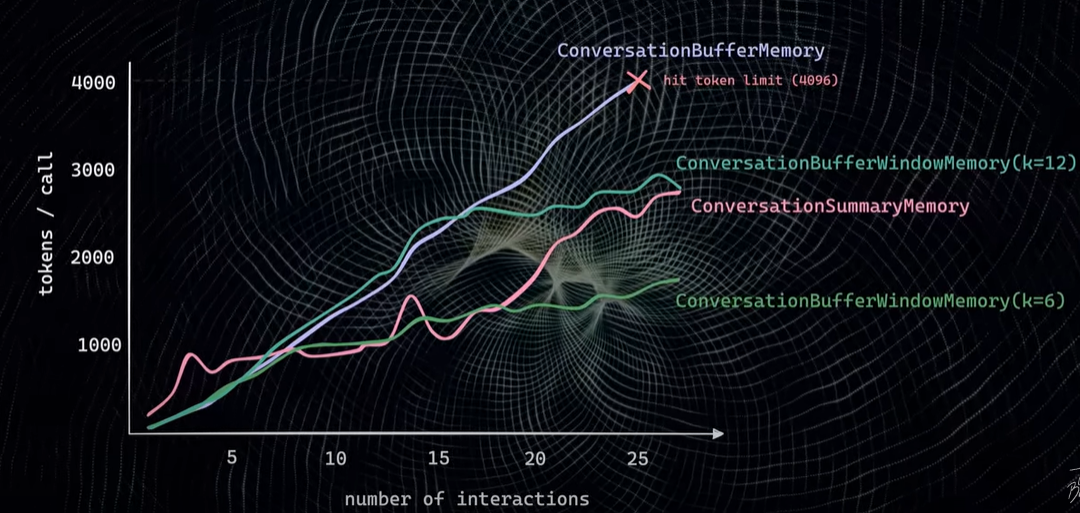

In [1]:
from IPython.display import Image
Image(filename="./memory.png")